# Yelp Exploration

In [24]:
%matplotlib inline

from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import *
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from functools import reduce
from mpl_toolkits.mplot3d import Axes3D
from sklearn import mixture
from sklearn.naive_bayes import GaussianNB


In [15]:
%%time
# reviews = pd.read_csv('input/yelp_review.csv') # will take over 2 minutes
reviews = pd.read_csv('input/yelp_review.csv', nrows=10000) # essentially instant

Wall time: 116 ms


In [16]:
%%time
businesses = pd.read_csv('input/yelp_business.csv')

Wall time: 592 ms


In [17]:
%%time
attributes = pd.read_csv('input/yelp_business_attributes.csv', 
                             dtype='category', na_values='Na', true_values='True', false_values='False')
attribute_names = attributes.drop('business_id', axis=1).columns
attributes[attribute_names] = attributes[attribute_names].apply(lambda x: x.cat.codes)

Wall time: 1.54 s


In [18]:
joined = businesses.merge(attributes, on='business_id').set_index('business_id')
joined.head()

,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Corkage,DietaryRestrictions_dairy-free,DietaryRestrictions_gluten-free,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian,AgesAllowed,RestaurantsCounterService
business_id,,,,,,,,,,,,,,,,,,,,,
FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",NaN,"""Richterstr. 11""",Stuttgart,BW,70567,48.727200,9.147950,4.0,5,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


## PCA analysis for the attributes database

Explained variance by component


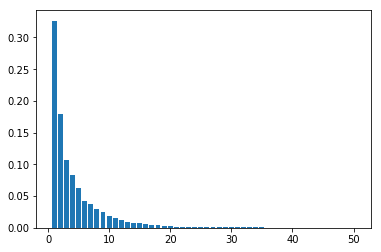


Explained variance up to...


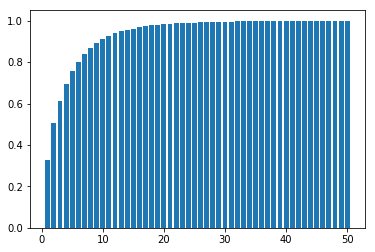

In [19]:
y_atts = pd.Series([int(x) for x in joined['stars']]) #round star ratings
x_atts = joined[joined.columns[12:]] #all the business attributes
x_atts_train, x_atts_dev, y_atts_train, y_atts_dev = train_test_split(x_atts, y_atts, test_size=.2, random_state=0)
pca = PCA()
pca.fit(x_atts_train)
print('Explained variance by component')
plt.bar(height = pca.explained_variance_ratio_[0:50], x = list(range(1,51)))
plt.show()
accrued = []
print()
print('Explained variance up to...')
for k in range(1,51):
    accrued.append(reduce(lambda x,y: x + y, pca.explained_variance_ratio_[0:k]))
plt.bar(height = accrued, x = list(range(1,51)))    
plt.show()

0


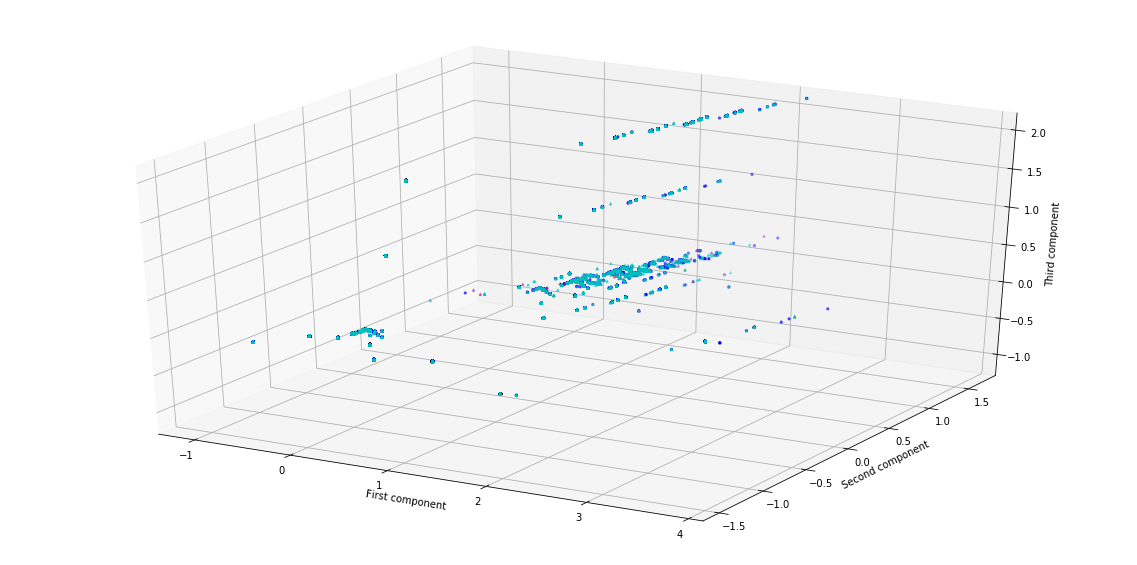

In [20]:
pca = PCA(n_components = 3)
td = pca.fit_transform(x_atts_train)
star_1 = td[y_atts_train == 1]
star_2 = td[y_atts_train == 2]
star_3 = td[y_atts_train == 3]
star_4 = td[y_atts_train == 4]
star_5 = td[y_atts_train == 5]
print(star_1.shape[0]+star_2.shape[0]+star_3.shape[0]+star_4.shape[0]+star_5.shape[0]-td.shape[0]) #check that calculations are correct

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

for c, m, star in [('r', 'o', star_1), ('g', '^', star_2), ('b', 'o', star_3), ('c', '^', star_4), ('m', '^', star_5)]:
    xs = star[:,0]
    ys = star[:,1]
    zs = star[:,2]
    ax.scatter(xs, ys, zs, c=c, marker=m, s=5, zdir = 'x')

ax.set_xlabel('First component')
ax.set_ylabel('Second component')
ax.set_zlabel('Third component')

plt.show()

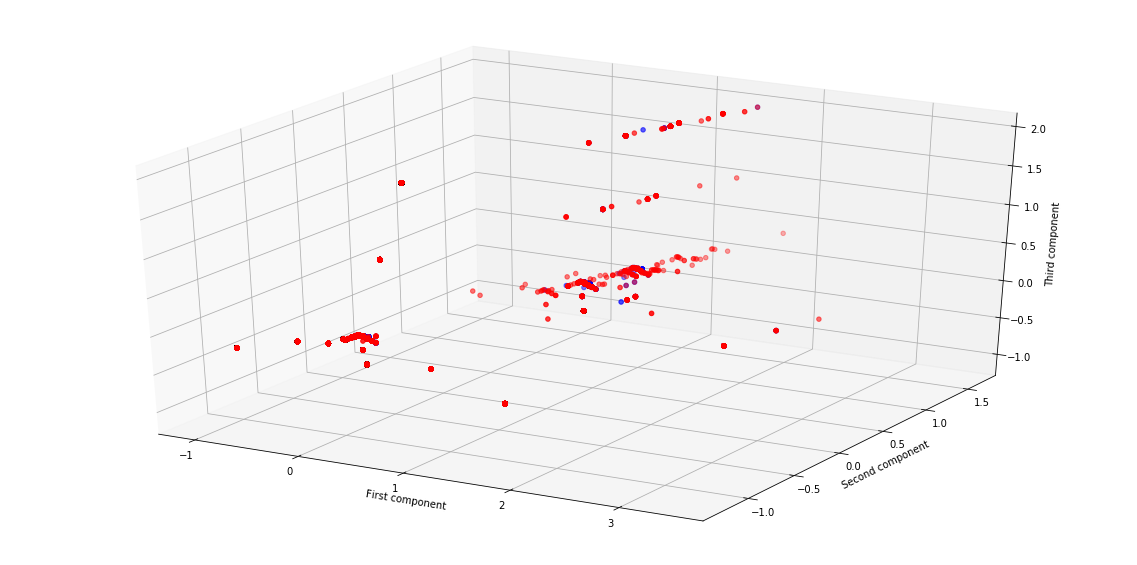

In [21]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

for c, m, star in [('b', 'o', star_1), ('r', 'o', star_5)]:
    xs = star[:,0]
    ys = star[:,1]
    zs = star[:,2]
    ax.scatter(xs, ys, zs, c=c, marker=m, s=20, zdir = 'x')

ax.set_xlabel('First component')
ax.set_ylabel('Second component')
ax.set_zlabel('Third component')

plt.show()

Visually, it doesn't seems that there's a way to separate the star rating by the content of the attributes. But it could be that there is a solution in higher dimensions or using non linear models.

## Predictive model using only PCA components

## Gaussian mixtures

In [22]:
cov_mat = ['spherical', 'diag', 'tied', 'full']
n_GMM = [6,4,3,2]
acc = []
y_atts_dev = y_atts_dev.reset_index(drop = True)
x_atts_dev = x_atts_dev.reset_index(drop = True)
bin_y_atts_dev = y_atts_dev[(y_atts_dev==1) | (y_atts_dev==5)]
bin_x_atts_dev = x_atts_dev[(y_atts_dev==1) | (y_atts_dev==5)]

for k in range(0,len(cov_mat)):
    for i in range(0,len(n_GMM)):
        pca = PCA(n_components = 6)
        td = pca.fit_transform(x_atts_train)
        star_1 = td[y_atts_train == 1]
        star_5 = td[y_atts_train == 5]
        tst = pca.fit_transform(bin_x_atts_dev)
        clf = mixture.GaussianMixture(n_components = n_GMM[i], covariance_type = cov_mat[k], random_state = 0)
        clf_td_5 = clf.fit(star_5)
        tst_mat_5 = np.exp(clf_td_5.score_samples(tst))
        clf_td_1 = clf.fit(star_1)
        tst_mat_1 = np.exp(clf_td_1.score_samples(tst))
        y_pred = [5 if tst_mat_5[j] > tst_mat_1[j] else 1 for j in range(0,len(tst_mat_5))]
        num = [1 if y_pred[j] == bin_y_atts_dev.iloc[j] else 0 for j in range(0,len(y_pred))]
        acc.append(sum(num)/len(y_pred))
mx = acc.index(max(acc))
a = mx//4
b = mx-a*4
print('Maximum accuracy was ', acc[mx], "\n", "It was achieved using 6 PCA components, ", n_GMM[b], " GMM components, with a ", cov_mat[a], " covariance matrix")

Maximum accuracy was  0.8043361404766171 
 It was achieved using 6 PCA components,  6  GMM components, with a  full  covariance matrix


## Support Vector Machine

In [23]:
#Using all labels
print('All labels')
svc = LinearSVC()
svc.fit(td, y_atts_train)
tst = pca.fit_transform(x_atts_dev)
print(metrics.classification_report(y_atts_dev, svc.predict(tst)))
print()
print('Binarized data')
bin_td = td[(y_atts_train==1) | (y_atts_train==5)]
bin_y_atts_train = y_atts_train[(y_atts_train==1) | (y_atts_train==5)]
svc.fit(bin_td, bin_y_atts_train)
bin_tst = pca.fit_transform(bin_x_atts_dev)
print(metrics.classification_report(bin_y_atts_dev, svc.predict(tst)))


All labels


c:\users\sm_fe\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          1       0.00      0.00      0.00      1092
          2       0.00      0.00      0.00      4257
          3       0.38      0.29      0.33      9938
          4       0.35      0.69      0.47     10633
          5       0.35      0.17      0.23      4489

avg / total       0.30      0.36      0.31     30409


Binarized data
             precision    recall  f1-score   support

          1       0.67      0.01      0.03      1092
          5       0.81      1.00      0.89      4489

avg / total       0.78      0.81      0.72      5581



## Gaussian Naive Bayes

In [29]:
gnb = GaussianNB()
gnb = gnb.fit(td, y_atts_train)
y_pred = gnb.predict(tst)
print("Classification report for GaussianNB - All labels")
print(metrics.classification_report(y_atts_dev,y_pred))
gnb = gnb.fit(bin_td, bin_y_atts_train)
y_pred = gnb.predict(bin_tst)
print("Classification report for GaussianNB - Binarized data")
print(metrics.classification_report(bin_y_atts_dev,y_pred))

Classification report for GaussianNB - All labels
             precision    recall  f1-score   support

          1       0.09      0.04      0.06      1092
          2       0.17      0.07      0.10      4257
          3       0.42      0.38      0.40      9938
          4       0.38      0.36      0.37     10633
          5       0.28      0.54      0.36      4489

avg / total       0.34      0.34      0.33     30409

Classification report for GaussianNB - Binarized data
             precision    recall  f1-score   support

          1       0.18      0.29      0.23      1092
          5       0.80      0.68      0.74      4489

avg / total       0.68      0.61      0.64      5581



## Decision Tree

In [30]:
%%time

dt = DecisionTreeClassifier()
dt.fit(td, y_atts_train)
print("Classification report for Decision Tree - All labels")
print(metrics.classification_report(y_atts_dev, dt.predict(tst)))
dt.fit(bin_td, bin_y_atts_train)
print("Classification report for Decision Tree - Binarized data")
print(metrics.classification_report(bin_y_atts_dev, dt.predict(bin_tst)))

Classification report for Decision Tree - All labels
             precision    recall  f1-score   support

          1       0.03      0.00      0.00      1092
          2       0.15      0.15      0.15      4257
          3       0.36      0.25      0.29      9938
          4       0.38      0.56      0.45     10633
          5       0.27      0.20      0.23      4489

avg / total       0.31      0.33      0.31     30409

Classification report for Decision Tree - Binarized data
             precision    recall  f1-score   support

          1       0.17      0.21      0.19      1092
          5       0.80      0.76      0.78      4489

avg / total       0.67      0.65      0.66      5581

Wall time: 167 ms


## Random Forest

In [32]:
%%time

rf = RandomForestClassifier()
rf.fit(td, y_atts_train)
print("Classification report for Random Forest - All labels")
print(metrics.classification_report(y_atts_dev, rf.predict(tst)))
rf.fit(bin_td, bin_y_atts_train)
print("Classification report for Random Forest - Binarized data")
print(metrics.classification_report(bin_y_atts_dev, rf.predict(bin_tst)))

Classification report for Random Forest - All labels
             precision    recall  f1-score   support

          1       0.00      0.00      0.00      1092
          2       0.15      0.14      0.14      4257
          3       0.34      0.26      0.30      9938
          4       0.38      0.66      0.48     10633
          5       0.31      0.02      0.04      4489

avg / total       0.31      0.34      0.29     30409

Classification report for Random Forest - Binarized data
             precision    recall  f1-score   support

          1       0.40      0.04      0.07      1092
          5       0.81      0.99      0.89      4489

avg / total       0.73      0.80      0.73      5581

Wall time: 579 ms


In [34]:
%%time

lr = LogisticRegression(penalty='l1', C=2)
lr.fit(td, y_atts_train)
print("Classification report for Logistic regression - All labels")
print(metrics.classification_report(y_atts_dev, lr.predict(tst)))
lr.fit(bin_td, bin_y_atts_train)
print("Classification report for Logistic regression - Binarized data")
print(metrics.classification_report(bin_y_atts_dev, lr.predict(bin_tst)))

Classification report for Logistic regression - All labels
             precision    recall  f1-score   support

          1       0.00      0.00      0.00      1092
          2       0.00      0.00      0.00      4257
          3       0.38      0.29      0.33      9938
          4       0.35      0.69      0.47     10633
          5       0.35      0.17      0.23      4489

avg / total       0.30      0.36      0.31     30409

Classification report for Logistic regression - Binarized data
             precision    recall  f1-score   support

          1       0.67      0.01      0.03      1092
          5       0.81      1.00      0.89      4489

avg / total       0.78      0.81      0.72      5581

Wall time: 531 ms


c:\users\sm_fe\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### End of Sergio's section, this will look a lot more organized when we merge the different bits of code...

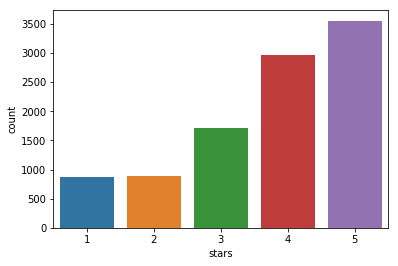

In [4]:
sns.countplot('stars', data=reviews)

In [5]:
train_data, dev_data, train_labels, dev_labels = \
    train_test_split(reviews.text.values, reviews.stars.values, test_size=.1, random_state=0)

## Count Vectorizer

In [6]:
cv = CountVectorizer(stop_words='english')
train_dtm = cv.fit_transform(train_data)
dev_dtm = cv.transform(dev_data)

lr = LogisticRegression()
lr.fit(train_dtm, train_labels)

print(metrics.classification_report(dev_labels, lr.predict(dev_dtm)))

             precision    recall  f1-score   support

          1       0.69      0.63      0.66        94
          2       0.38      0.30      0.33        87
          3       0.38      0.30      0.34       175
          4       0.46      0.51      0.49       300
          5       0.61      0.66      0.64       344

avg / total       0.51      0.52      0.51      1000



In [7]:
len(cv.get_feature_names())

30044

## TFIDF Vectorizer

In [8]:
tv = TfidfVectorizer(stop_words='english')
train_dtm2 = tv.fit_transform(train_data)
dev_dtm2 = tv.transform(dev_data)

lr2 = LogisticRegression()
lr2.fit(train_dtm2, train_labels)

print(metrics.classification_report(dev_labels, lr2.predict(dev_dtm2)))

             precision    recall  f1-score   support

          1       0.77      0.54      0.64        94
          2       0.47      0.09      0.15        87
          3       0.47      0.29      0.36       175
          4       0.48      0.57      0.52       300
          5       0.59      0.78      0.68       344

avg / total       0.54      0.55      0.52      1000



## SVM

Interestingly, an SVM is horrible if we use the count vectorizer but on par with logistic regression if we use the tf-idf vectorizer.  Fitting is also much faster with tf-idf as well.

In [9]:
svc = LinearSVC()
svc.fit(train_dtm, train_labels)
print(metrics.classification_report(dev_labels, svc.predict(dev_dtm)))

             precision    recall  f1-score   support

          1       0.68      0.55      0.61        94
          2       0.33      0.32      0.32        87
          3       0.35      0.32      0.34       175
          4       0.42      0.45      0.43       300
          5       0.59      0.62      0.60       344

avg / total       0.48      0.48      0.48      1000



In [10]:
svc2 = LinearSVC()
svc2.fit(train_dtm2, train_labels)
print(metrics.classification_report(dev_labels, svc2.predict(dev_dtm2)))

             precision    recall  f1-score   support

          1       0.68      0.65      0.66        94
          2       0.38      0.24      0.30        87
          3       0.38      0.33      0.35       175
          4       0.45      0.50      0.47       300
          5       0.62      0.68      0.65       344

avg / total       0.51      0.52      0.52      1000

